In [216]:
import pandas as pd
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks

In [217]:
df=pd.read_csv(r"C:\projects\thinkclock\cleaned_dataset\metadata.csv")

In [218]:
df.isnull().sum()

type                      0
start_time                0
ambient_temperature       0
battery_id                0
test_id                   0
uid                       0
filename                  0
Capacity               4771
Re                     5609
Rct                    5609
dtype: int64

In [219]:
df['Re'] = pd.to_numeric(df['Re'], errors='coerce')
df['Rct'] = pd.to_numeric(df['Rct'], errors='coerce')

In [220]:
def process_start_time(value):
    if isinstance(value, str):
        value = re.sub(r'\s+', ', ', value.strip())
        try:
            parsed = ast.literal_eval(value)
            if len(parsed) >= 3:
                return f"{int(parsed[0]):04d}-{int(parsed[1]):02d}-{int(parsed[2]):02d}"
        except Exception:
            return None
    return value

df['start_time'] = df['start_time'].apply(process_start_time)
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')

In [221]:
df4=df.copy()

In [222]:
df['Re'] = df['Re'].fillna(df['Re'].median())
df['Rct'] = df['Rct'].fillna(df['Rct'].median())

TASK A :3d plot for eis measurements on how impedence is changing with respect to Aging 

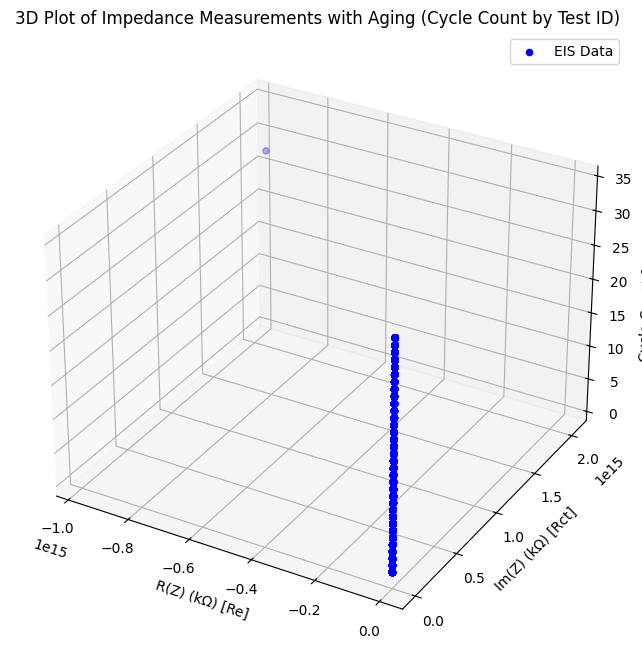

In [223]:
df['cycle_count'] = df.groupby('test_id')['start_time'].rank(method='first', ascending=True).astype(int)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Re'], df['Rct'], df['cycle_count'], c='b', label='EIS Data')
ax.set_xlabel("R(Z) (kΩ) [Re]")
ax.set_ylabel("Im(Z) (kΩ) [Rct]")
ax.set_zlabel("Cycle Count [test_id]")
ax.set_title("3D Plot of Impedance Measurements with Aging (Cycle Count by Test ID)")

plt.legend()
plt.show()

TASK B: A typical charge/discharge cycle data for a battery cell looks like the plot below a. From a, could you derive plot b for incremental capacity analysis showing dQ/dV versus V which indicates how the rate of capacity increment w.r.t. Voltage changes w.r.t. Voltage as the cell is charged or discharged?

Could you create a 3D plot showing how peaks in b change w.r.t. Aging (cycle count)."

In [230]:
df2=df4.copy()

In [231]:
df2['Re'] = pd.to_numeric(df2['Re'], errors='coerce')
df2['Rct'] = pd.to_numeric(df2['Rct'], errors='coerce')
df2['Capacity'] = pd.to_numeric(df2['Capacity'], errors='coerce')
filtered_df2 = df2[df2['type'].isin(['discharge', 'impedance'])]
task2_df = filtered_df2.groupby('battery_id', as_index=False).agg({
    'Re': 'mean',
    'Rct': 'mean',
    'Capacity': 'mean',
    'start_time': 'first',  
    'ambient_temperature': 'mean',  
    'test_id': 'first', 
    'uid': 'first',  
    'filename': 'first'  
})

print(task2_df)



   battery_id            Re           Rct  Capacity start_time  \
0       B0005  5.424465e-02  7.733956e-02  1.572502 2008-04-02   
1       B0006  7.005151e-02  9.302025e-02  1.546851 2008-04-02   
2       B0007  5.280665e-02  7.687381e-02  1.644421 2008-04-02   
3       B0018  6.297578e-02  8.908997e-02  1.557701 2008-07-07   
4       B0025  4.877618e-02  7.704753e-02  1.816511 2009-02-13   
5       B0026  9.011823e-02  1.148913e-01  1.775935 2009-02-13   
6       B0027  9.917740e-02  1.244205e-01  1.804885 2009-02-13   
7       B0028  8.002976e-02  1.081472e-01  1.770059 2009-02-13   
8       B0029  2.809331e-02  4.085891e-02  1.726012 2009-04-07   
9       B0030  6.418748e-02  7.524767e-02  1.661049 2009-04-07   
10      B0031  4.044504e-02  5.159026e-02  1.743189 2009-04-07   
11      B0032  7.221722e-02  8.042184e-02  1.754554 2009-04-07   
12      B0033  8.969975e-02  1.153484e-01  1.409510 2009-06-19   
13      B0034  1.252533e-01  1.472626e-01  1.386119 2009-06-19   
14      B0

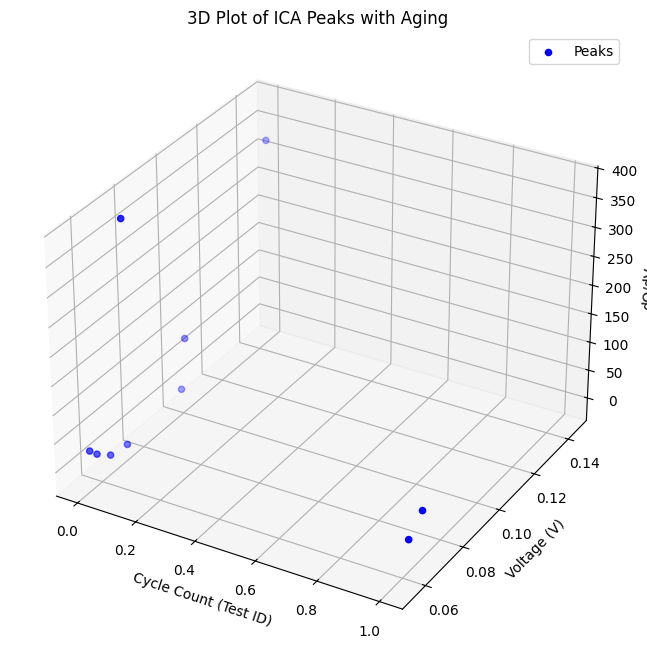

In [ ]:
task2_df['Capacity'] = pd.to_numeric(task2_df['Capacity'], errors='coerce')
task2_df['Re'] = pd.to_numeric(task2_df['Re'], errors='coerce')

task2_df = task2_df.dropna(subset=['Capacity', 'Re'])

task2_df['dQ/dV'] = np.gradient(task2_df['Capacity'], task2_df['Re'])

peaks, _ = find_peaks(task2_df['dQ/dV'], prominence=0.01)
peak_voltages = task2_df['Re'].iloc[peaks]
peak_values = task2_df['dQ/dV'].iloc[peaks]
cycle_counts = task2_df['test_id'].iloc[peaks] 

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cycle_counts, peak_voltages, peak_values, c='blue', label='Peaks')
ax.set_xlabel('Cycle Count (Test ID)')
ax.set_ylabel('Voltage (V)')
ax.set_zlabel('dQ/dV')
ax.set_title('3D Plot of ICA Peaks with Aging')

plt.legend()
plt.show()


TASK C: train a model 

In [236]:
df3=task2_df.copy()

In [237]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   battery_id           34 non-null     object        
 1   Re                   34 non-null     float64       
 2   Rct                  34 non-null     float64       
 3   Capacity             34 non-null     float64       
 4   start_time           34 non-null     datetime64[ns]
 5   ambient_temperature  34 non-null     float64       
 6   test_id              34 non-null     int64         
 7   uid                  34 non-null     int64         
 8   filename             34 non-null     object        
 9   dQ/dV                34 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 2.8+ KB


In [238]:
df3['Re'] = pd.to_numeric(df3['Re'], errors='coerce') 
df3['Rct'] = pd.to_numeric(df3['Rct'], errors='coerce') 
df3['Capacity'] = pd.to_numeric(df3['Capacity'], errors='coerce') 

In [239]:
X = df3[['Re', 'Rct']]
y = df3['Capacity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [240]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [241]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [242]:
y_pred = rf_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [243]:
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 0.12159336807316198
R² Score: -0.18214318891440762


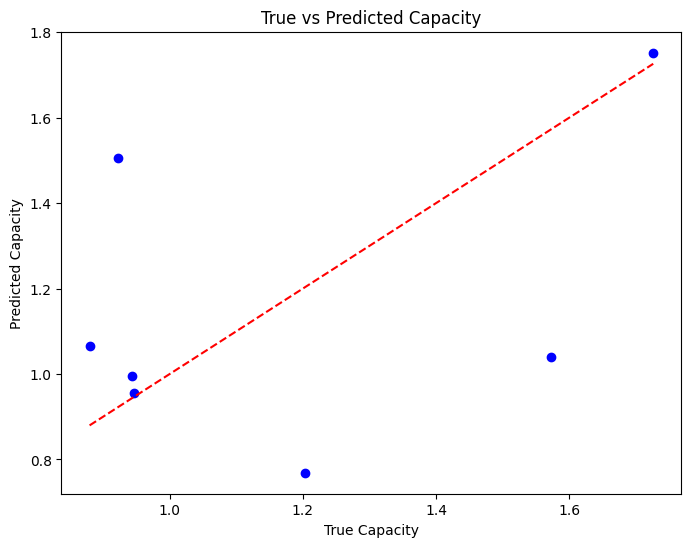

In [244]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Capacity')
plt.ylabel('Predicted Capacity')
plt.title('True vs Predicted Capacity')
plt.show()